# Analyzing player behavior to predict usage of a Minecraft research server

## Introduction

### Background

Minecraft is a sandbox, open-world video game developed by Mojang Studios where players explore, build and interact in a three-dimensional virtual world made of blocks. Players can build structures, gather resources and craft items to aid their survival, either individually or with other players in a multiplayer server (Minecraft.net, 2023). This makes it an ideal platform for studying player behaviors in a video game.

A research group led by Professor Frank Wood wants to assess how people play video games. To do this, they have set up a Minecraft server where players' interactions are recorded in detailed session logs. However, in doing so they face challenges such as identifying which players are most valuable to recruit and ensuring they have the resources necessary. Understanding period where most sessions are played is crucial in maintaining the scale of the research and minimizing the cost. Different time periods may contribute to the different amount of data, which leads to requiring levels of technical support, and placing different demands on valuable resources during those time periods. By identifying the different time periods through clustering analysis, research teams can ensure adequate resource management.

### Question

This project aims to answer the question: **Are there distinct time-of-day or day-of-week usage patterns to manage the resources spent for each time of the day or day of the week?**

### Data Description

We will be using the `sessions.csv` dataset provided by the research group to determine which time periods most valuable to optimize the resource management and ensure they have the resources necessary. 

The dataset is structured as follows:

1. `hasedEmail`: encrypted email for each player
2. `start_time`: start time of session
3. `end_time`: end time of session
4. `original_start_time`: computer tracked start time (number of seconds from Jan 1 1970)
5. `original_end_time`: computer tracked end time (number of seconds from Jan 1 1970)

This dataset contains **1535** unique sessions.

## Methods & Result

### Load data and wrangle data

1. To begin analysis, we need to load all the necessary libraries and import the datasets. Load the `sessions.csv` data and assign it to the object `sessions` using `read_csv`. Since we won't be using the original times and hasedEmail, we can remove those columns.
2. We need to parse the data from the dataset into the approproiate time format which is `day/month/year hour:minute`. We also need to seperate the session start times and end times into their respective day of the week and hour of the day. Some session duration may be 0 so we have to filter these out too.

In [48]:
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
library(tidyclust)
options(repr.matrix.max.rows = 6)

sessions <- read.csv("data/sessions.csv") |> select(start_time, end_time)
head(sessions)

,start_time,end_time
,<chr>,<chr>
1,30/06/2024 18:12,30/06/2024 18:24
2,17/06/2024 23:33,17/06/2024 23:46
3,25/07/2024 17:34,25/07/2024 17:57
4,25/07/2024 03:22,25/07/2024 03:58
5,25/05/2024 16:01,25/05/2024 16:12
6,23/06/2024 15:08,23/06/2024 17:10


In [49]:
sessions_clean <- sessions |>
  mutate(
    start_time = dmy_hm(start_time),  # Parse day/month/year hour:minute|
    start_time_day_of_week = wday(start_time, label = TRUE, abbr = FALSE),  # e.g., "Monday"
    start_time_hrs = hour(start_time) + minute(start_time)/60, # Convert to decimal hour
    end_time = dmy_hm(end_time),  # Parse day/month/year hour:minute
    end_time_day_of_week = wday(end_time, label = TRUE, abbr = FALSE),  # e.g., "Monday"
    end_time_hrs = hour(end_time) + minute(end_time)/60, # Convert to decimal hour
    session_duration_mins = as.numeric(difftime(end_time, start_time, units = "hours"))
  ) |>
  filter(!is.na(session_duration_mins), session_duration_mins > 0)
sessions_clean

start_time,end_time,start_time_day_of_week,start_time_hrs,end_time_day_of_week,end_time_hrs,session_duration_mins
<dttm>,<dttm>,<ord>,<dbl>,<ord>,<dbl>,<dbl>
2024-06-30 18:12:00,2024-06-30 18:24:00,Sunday,18.20000,Sunday,18.40000,0.2000000
2024-06-17 23:33:00,2024-06-17 23:46:00,Monday,23.55000,Monday,23.76667,0.2166667
2024-07-25 17:34:00,2024-07-25 17:57:00,Thursday,17.56667,Thursday,17.95000,0.3833333
⋮,⋮,⋮,⋮,⋮,⋮,⋮
2024-07-28 15:36:00,2024-07-28 15:57:00,Sunday,15.600000,Sunday,15.950000,0.3500000
2024-07-25 06:15:00,2024-07-25 06:22:00,Thursday,6.250000,Thursday,6.366667,0.1166667
2024-05-20 02:26:00,2024-05-20 02:45:00,Monday,2.433333,Monday,2.750000,0.3166667


### Summarizing and Visualizing
1. We can summarize the wrangled data to see if there any reccuring patterns and distributions such as what time of day and which day of the week do most people play at.
2. View this summary through a visualization.

In [50]:
sessions_clean |>
  mutate(hour_bin = floor(start_time_hrs)) |>
  count(hour_bin) |>
  arrange(desc(n))

sessions_clean |>
  group_by(start_time_day_of_week) |>
  summarise(
    total_duration = sum(session_duration_mins, na.rm = TRUE),
    average_duration = mean(session_duration_mins, na.rm = TRUE),
    num_sessions = n()
  ) |>
  arrange(desc(total_duration))  # Or use average_duration to sort differently

hour_bin,n
<dbl>,<int>
2,152
4,150
3,131
⋮,⋮
10,3
13,2
12,1


start_time_day_of_week,total_duration,average_duration,num_sessions
<ord>,<dbl>,<dbl>,<int>
Saturday,257.3500,0.9860153,261
Sunday,247.8667,0.9994624,248
Tuesday,176.8000,0.8709360,203
⋮,⋮,⋮,⋮
Wednesday,158.2833,0.7537302,210
Thursday,150.3167,0.6740658,223
Monday,146.7167,0.7087762,207


From the summary tables, we can see that most players played on Saturdays and most people prefer to play at around 2 AM.

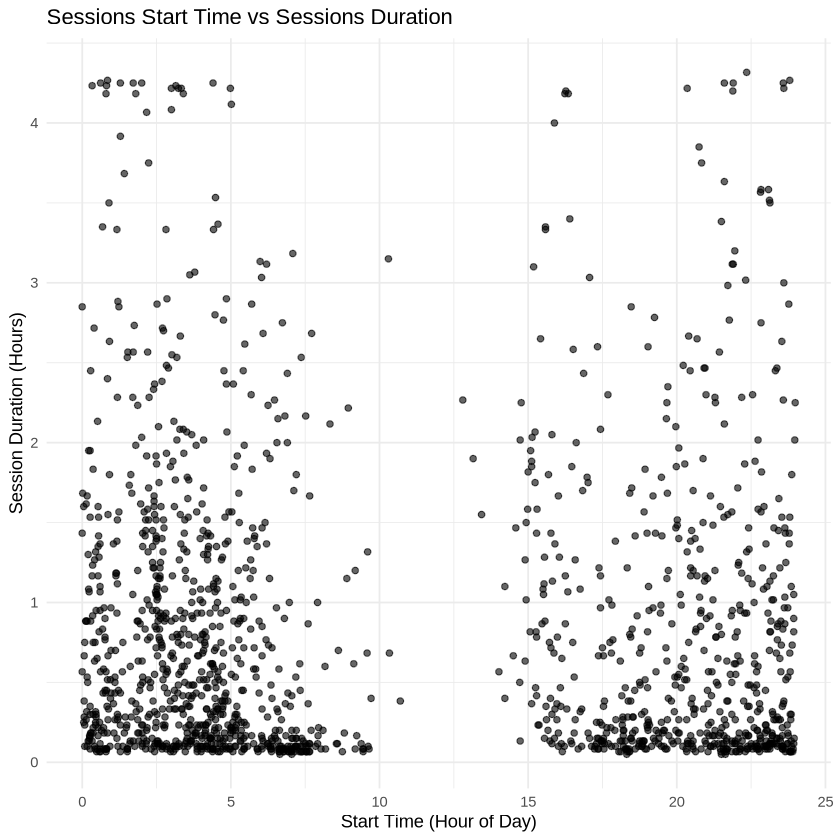

In [54]:
sessions_plot = ggplot(sessions_clean, aes(x = start_time_hrs, y = session_duration_mins)) +
  geom_point(alpha = 0.6, size = 1.5) +
  scale_x_continuous(name = "Start Time (Hour of Day)") +
  scale_y_continuous(name = "Session Duration (Hours)") +
  labs(title = "Sessions Start Time vs Sessions Duration") +
  theme_minimal()
sessions_plot

This plot shows when longer and shorter sessions tend to occur, helping us assess demand at different times of the week. For instance, longer sessions may cluster on weekends. We can see that most sessions are played from 3 in the afternoon to 10 in the morning.

### Clustering Analysis

1. We need to scale and center before using K-means clustering because since it uses Euclidean distance otherwise, variables with larger numeric ranges (e.g., minutes vs hours) will dominate the clustering.
2. Since we don’t know the best number of clusters, for `num_clusters` parameter, we use `tune()`. This allows us to try different values and choose the best one based on within cluster sum-of-squares distance (WSSD).
3. Build a workflow, then we tune the model for different number of clusters `k` to find the best value of `k`. We can visualize the best value of `k` by plotting each value to their WSSD.
4. After finding the best value for `k`, we can find visualize the clusters.

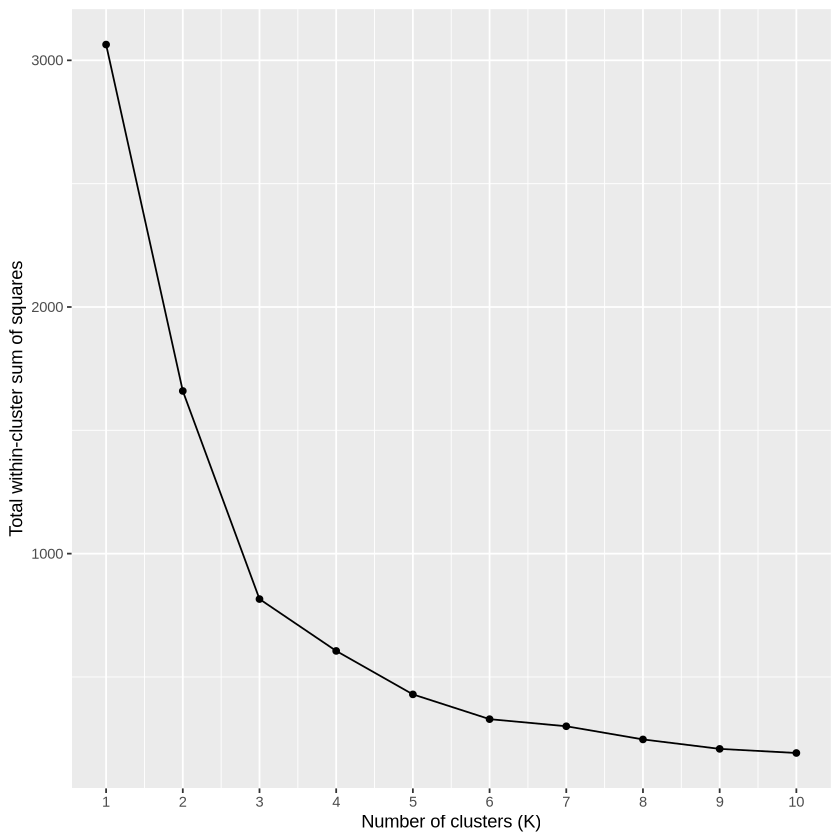

In [55]:
set.seed(123)

k_values <- tibble(num_clusters = seq(1, 10, by = 1)) 

sessions_spec = k_means(num_clusters = tune()) |>
    set_engine("stats")

recipe = recipe(~ start_time_hrs + session_duration_mins, data = sessions_clean) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors())

elbow_stats = workflow() |>
    add_recipe(recipe) |>
    add_model(sessions_spec) |>
    tune_cluster(resamples = apparent(sessions_clean), grid = k_values) |>
    collect_metrics() |>
    filter(.metric == "sse_within_total") |>
    mutate(total_WSSD = mean) |>
    select(num_clusters, total_WSSD)
    
elbow_plot = elbow_stats |>
    ggplot(aes(x=num_clusters, y=total_WSSD)) +
    geom_point() +
    geom_line() +
    scale_x_continuous(breaks = seq(1, 10, by = 1)) +
    labs(x="Number of clusters (K)", y="Total within-cluster sum of squares")
elbow_plot

From this elbow plot, we look for the “elbow point” to choose an optimal number of clusters. In this example, we can see that the most suitable number of clusters is `k` = 2 because as we increase the number of clusters, the WSSD decreases very slightly.

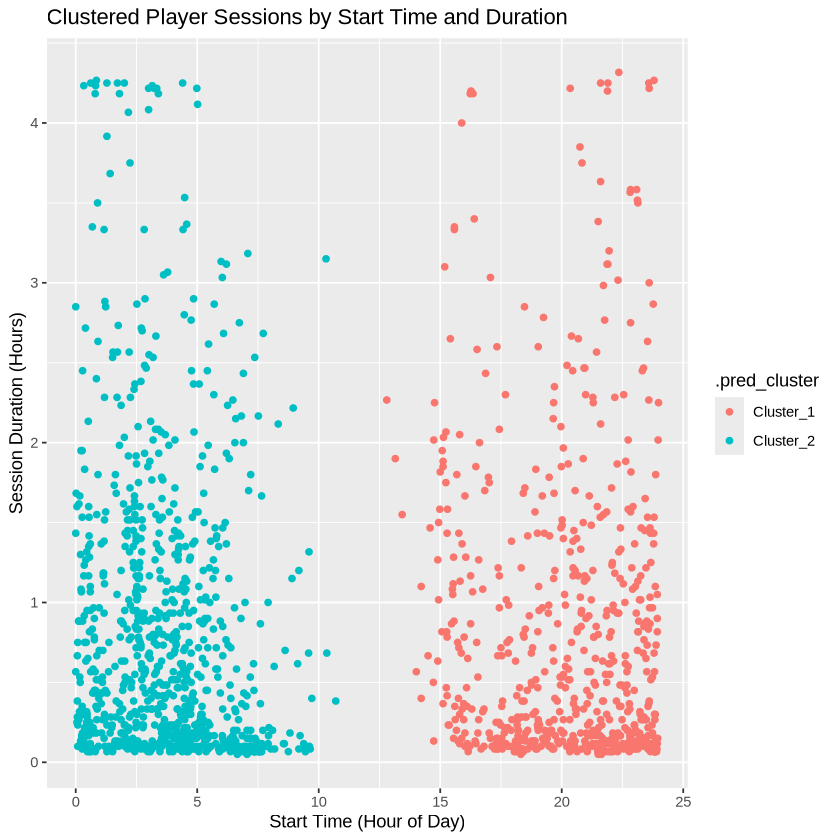

In [57]:
set.seed(123)

sessions_final_kmeans <- k_means(num_clusters = 2) |> set_engine("stats")
sessions_final_clustering <- workflow() |>
    add_recipe(recipe) |>
    add_model(sessions_final_kmeans) |>
    fit(sessions_clean)
sessions_final_clusters <- sessions_final_clustering |> 
    augment(sessions_clean)

sessions_final_clusters_plot = sessions_final_clusters |>
    ggplot(aes(x = start_time_hrs, y = session_duration_mins, color=.pred_cluster)) +
    geom_point() +
  scale_x_continuous(name = "Start Time (Hour of Day)") +
  scale_y_continuous(name = "Session Duration (Hours)") +
  labs(title = "Clustered Player Sessions by Start Time and Duration")
sessions_final_clusters_plot

This visualization allows us to interpret cluster patterns. We can see that there are 2 distinct clusters, one around midnight to around 10 AM, another from around 3 PM to midnight. This suggests that players tend to game either late night to early morning or late afternoon to evening with a few gaming from around 10 AM to 3 PM.

## Discussion

Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent vel ligula scelerisque, feugiat erat vel, tincidunt justo. Curabitur ac sapien nec justo tincidunt interdum. Integer nec libero nec nisi tincidunt vehicula. Fusce id velit ut libero pulvinar facilisis. Sed euismod, nisl eget consectetur fermentum, nisi libero ultricies nunc, nec tincidunt sapien eros nec libero. Nullam id felis ut elit tincidunt pharetra. Suspendisse potenti. Proin ac orci vel arcu tincidunt pharetra. Integer vel nisi nec justo dictum tincidunt ut ac purus.

## References

Landin, Per. “What is Minecraft.” Minecraft.net, 5 June 2023, www.minecraft.net/en-us/article/what-minecraft.

